# Subscriber Bike Share Model

**Import pacakges**

In [176]:
import warnings
warnings.filterwarnings('ignore')

In [177]:
import pandas.io.data as web
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
import math
import statsmodels as sm
import seaborn as sns
import pylab
import pprint
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smgraph
import scipy.stats as stats

from pandas.tools.plotting import scatter_matrix
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics

%matplotlib inline
sns.set_palette("Set2", 10) #Set color scheme
sns.set_style("darkgrid") #Set style for axis
pd.set_option('display.max_rows', 500)

In [178]:
#Import data files
bike_df = pd.read_csv('bike_combined.csv')
model_df = bike_df.copy()

In [179]:
#Create weekday/weekend dummy
model_df.Date = pd.to_datetime(model_df.Date)
model_df['Weekday'] = model_df.Date.dt.weekday_name
week_dummy = pd.get_dummies(model_df.Weekday)
model_df = pd.concat([model_df, week_dummy], axis = 1)
model_df.drop(['Weekday'], axis = 1, inplace = True)

#Season dummy
season_dummy = pd.get_dummies(model_df.Season_Name)
model_df = pd.concat([model_df, season_dummy], axis = 1)
model_df.drop(['Season_Name'], axis = 1, inplace = True)

#Dummy for City
model_df.City = model_df.City.replace({'DC': 1, 'Chicago': 0})

#Drop NaN rows
model_df = model_df.dropna(how = 'any')

#Replace T value
model_df = model_df.replace({'T' : 0}, regex = True)

#Outlier adjust
# model_df = model_df[model_df.Subscriber_sum > 3000]

# Data Set Decriptive Stats

In [180]:
model_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_sum,2207.0,2200.065700,2248.168768,2.000000,499.500000,1643.000000,3030.500000,18280.000000
Subscriber_sum,2207.0,6355.984594,3192.462047,52.000000,3805.500000,6666.000000,8756.000000,14268.000000
Total_Count sum,2207.0,8556.050295,4509.411632,56.000000,4805.000000,8930.000000,11713.000000,24989.000000
Season,2207.0,2.630267,1.076473,1.000000,2.000000,3.000000,4.000000,4.000000
Holiday,2207.0,0.027639,0.163974,0.000000,0.000000,0.000000,0.000000,1.000000
Duration_mean,2207.0,16.040797,4.760595,8.871921,12.404918,15.288303,18.078578,41.802399
DAILYAverageDryBulbTemp,2207.0,57.221568,19.551785,-9.000000,44.000000,60.000000,74.000000,91.000000
DAILYDeptFromNormalAverageTemp,2207.0,0.834708,8.016329,-32.900000,-3.800000,1.200000,6.000000,28.900000
DAILYAverageRelativeHumidity,2207.0,64.762121,13.211236,28.000000,56.000000,65.000000,74.000000,98.000000
DAILYCoolingDegreeDays,2207.0,4.362483,6.340591,0.000000,0.000000,0.000000,9.000000,26.000000


In [181]:
#Create log variable
model_df['log_subsciber'] = np.log(model_df.Subscriber_sum)

#Create dependent variable
y = model_df.log_subsciber

#Create independent variables
X = model_df.ix[:,'Season': 'Wednesday']

#Variables to drop
X.drop(['DAILYAverageStationPressure', 'DAILYDeptFromNormalAverageTemp', 'DAILYCoolingDegreeDays', 'DAILYSustainedWindDirection', 'DAILYAverageRelativeHumidity'], axis = 1, inplace = True)

# Dependent Variable Distributions

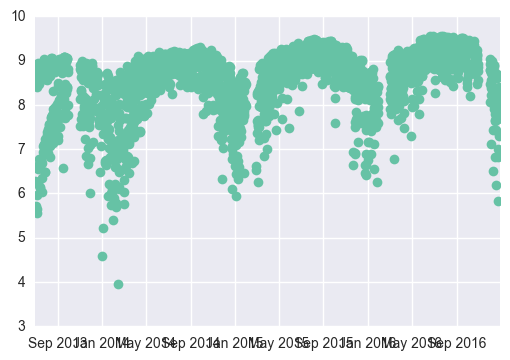

In [182]:
#Count over time
plt.plot_date(model_df.Date, model_df.log_subsciber, xdate = True)

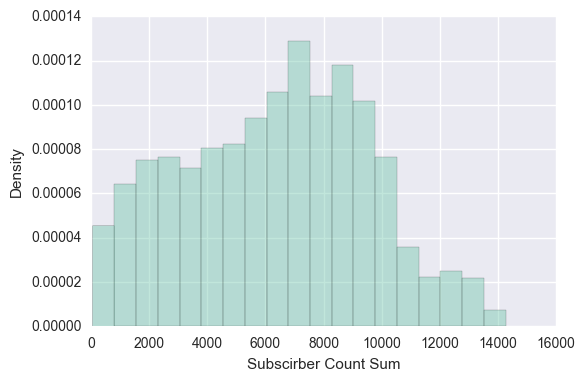

In [183]:
#Dependent distributions
ax = sns.distplot(model_df.Subscriber_sum, kde = False, rug = False, norm_hist = True)
plt.xlabel('Subscirber Count Sum')
ax.set_ylabel('Density')
plt.show()

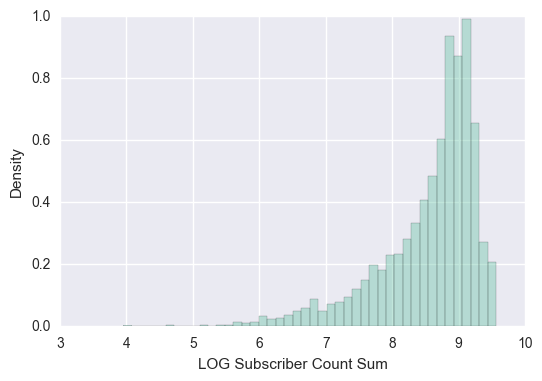

In [184]:
#Log distributions
ax = sns.distplot(y, kde = False, rug = False, norm_hist = True)
plt.xlabel('LOG Subscriber Count Sum')
ax.set_ylabel('Density')
plt.show()

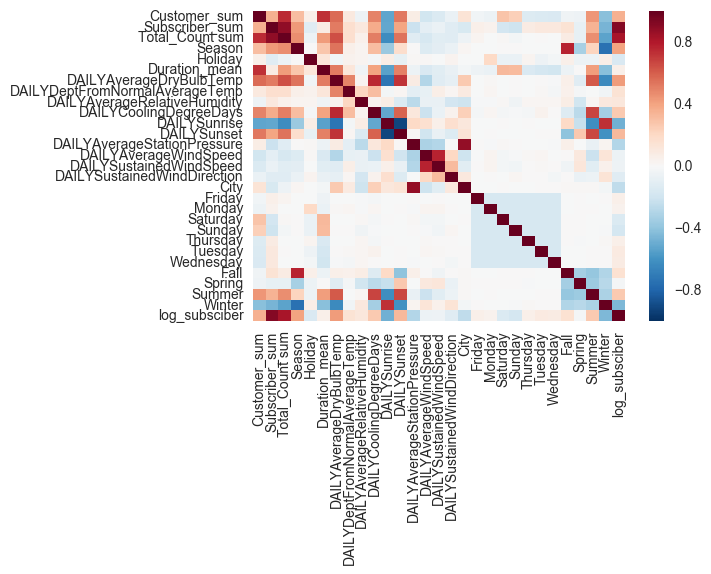

In [185]:
#Correlation Heatmap
corr = model_df.corr()
sns.heatmap(corr)

In [186]:
#Correlation Values List
corr = pd.DataFrame(model_df.corr())
corr.dropna(how='any')

#Dropped (Based on correlation and heatmap): 
# DAILYMaximumDryBulbTemp DAILYMinimumDryBulbTemp (Kept average)
# DAILYAverageSeaLevelPressure (Lower corr to dependent since redundant)
# DAILYPeakWindSpeed PeakWindDirection (Kept Average)
# DAILYAverageDewPointTemp DAILYAverageWetBulbTemp (Lower corr to dependent since redundant)

#Dropped (Based on correlation and heatmap): 
# DAILYMaximumDryBulbTemp DAILYMinimumDryBulbTemp (Kept average)
# DAILYAverageSeaLevelPressure (Lower corr to dependent since redundant)
# DAILYPeakWindSpeed PeakWindDirection (Kept Average)
# DAILYAverageDewPointTemp DAILYAverageWetBulbTemp (Lower corr to dependent since redundant)

,Customer_sum,Subscriber_sum,Total_Count sum,Season,Holiday,Duration_mean,DAILYAverageDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYAverageRelativeHumidity,DAILYCoolingDegreeDays,...,Saturday,Sunday,Thursday,Tuesday,Wednesday,Fall,Spring,Summer,Winter,log_subsciber
Customer_sum,1.000000,0.354506,0.749525,0.309320,0.055360,0.732274,0.564843,0.097446,-0.048107,0.495707,...,0.286814,0.239388,-0.133790,-0.144304,-0.151794,-0.039396,-0.047569,0.444604,-0.415033,0.352731
Subscriber_sum,0.354506,1.000000,0.884694,0.436078,-0.122876,0.082911,0.517815,0.167780,0.108836,0.370072,...,-0.185839,-0.210501,0.083449,0.103914,0.105690,0.144893,-0.085723,0.344268,-0.463644,0.915172
Total_Count sum,0.749525,0.884694,1.000000,0.462935,-0.059391,0.423773,0.648193,0.167362,0.053067,0.509129,...,0.011425,-0.029678,-0.007623,0.001624,-0.000853,0.082937,-0.084404,0.465384,-0.535154,0.823755
Season,0.309320,0.436078,0.462935,1.000000,0.001422,0.280223,0.544799,0.057039,0.026612,0.307019,...,0.001321,0.007782,-0.000954,-0.002295,-0.002602,0.766113,-0.331268,0.222213,-0.749454,0.402439
Holiday,0.055360,-0.122876,-0.059391,0.001422,1.000000,0.121247,-0.032876,0.040239,0.024799,-0.019233,...,-0.068666,-0.068793,0.025520,-0.052842,-0.029465,0.061150,-0.056672,-0.060566,0.062616,-0.148791
Duration_mean,0.732274,0.082911,0.423773,0.280223,0.121247,1.000000,0.516771,0.122633,-0.040184,0.398502,...,0.325779,0.313845,-0.152588,-0.178036,-0.188429,-0.062007,0.007069,0.417460,-0.417663,0.056259
DAILYAverageDryBulbTemp,0.564843,0.517815,0.648193,0.544799,-0.032876,0.516771,1.000000,0.496469,0.033120,0.751728,...,-0.002891,0.001074,-0.006096,0.007327,-0.008737,0.058858,-0.123679,0.615433,-0.638198,0.428699
DAILYDeptFromNormalAverageTemp,0.097446,0.167780,0.167362,0.057039,0.040239,0.122633,0.496469,1.000000,0.217235,0.307444,...,-0.005502,0.000350,-0.005191,0.012106,-0.016217,0.054025,-0.022067,-0.000842,-0.035299,0.142557
DAILYAverageRelativeHumidity,-0.048107,0.108836,0.053067,0.026612,0.024799,-0.040184,0.033120,0.217235,1.000000,0.038932,...,0.011459,-0.044825,0.016179,0.020985,0.022445,0.070778,-0.191138,0.018344,0.106353,0.115557
DAILYCoolingDegreeDays,0.495707,0.370072,0.509129,0.307019,-0.019233,0.398502,0.751728,0.307444,0.038932,1.000000,...,-0.018378,-0.009437,-0.016285,0.039731,0.001317,-0.128246,-0.272025,0.676484,-0.340301,0.258331


# Categorical Boxplots

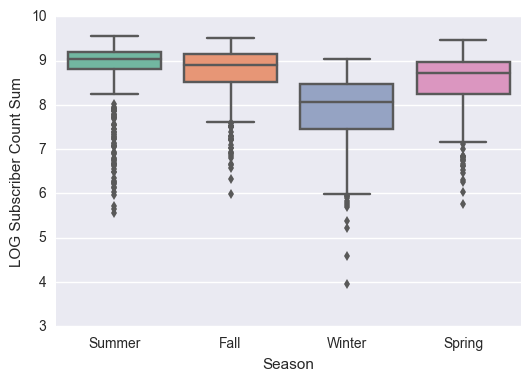

In [187]:
seasons_df = model_df[['log_subsciber', 'Season']]
#Log Weekday Boxplots
ax = sns.boxplot(y, groupby = bike_df.Season_Name)
ax.set_ylabel('LOG Subscriber Count Sum')
plt.xlabel('Season')
plt.show()

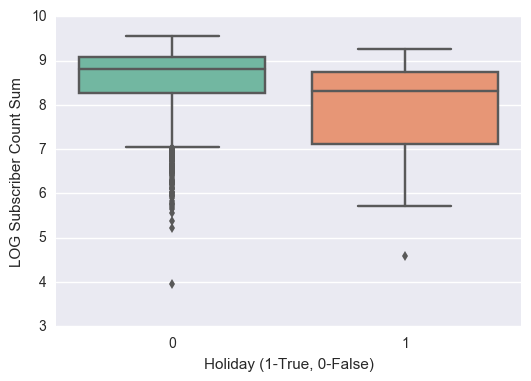

In [188]:
#Log Holiday Boxplots
ax = sns.boxplot(y, groupby = model_df.Holiday)
ax.set_ylabel('LOG Subscriber Count Sum')
plt.xlabel('Holiday (1-True, 0-False)')
plt.show()

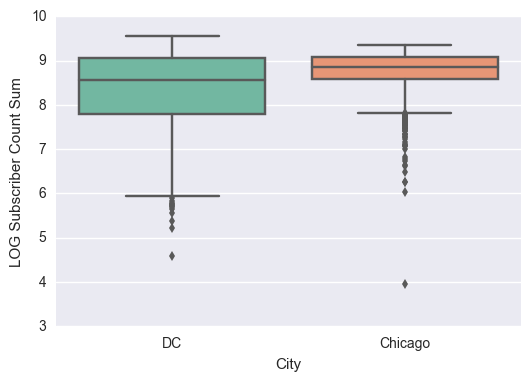

In [189]:
#Log City Boxplots
ax = sns.boxplot(y, groupby = bike_df.City)
ax.set_ylabel('LOG Subscriber Count Sum')
plt.show()

# Training and Test Sets

In [190]:
#Create training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7777)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1765, 17)
(1765,)
(442, 17)
(442,)


# Log-Linear Regression Model

In [191]:
#Linear Regression Model
lm = smf.OLS(y_train.astype(float), X_train.astype(float))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_subsciber   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     102.1
Date:                Sat, 03 Jun 2017   Prob (F-statistic):          1.68e-236
Time:                        16:05:28   Log-Likelihood:                -1396.7
No. Observations:                1765   AIC:                             2827.
Df Residuals:                    1748   BIC:                             2921.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Season                      0.0438      0.018      2.393      0.017         0.008     0.080
Holiday                    -0.5401      0.085     -6.360      0.000        -0.707    -0.374
Duration_mean              -0.0361      0.004     -8.040      0.000        -0.045    -0.027
DAILYAverageDryBulbTemp     0.0165      0.001     11.827      0.000         0.014     0.019
DAILYSunrise               -0.0054      0.001     -9.314      0.000        -0.007    -0.004
DAILYSunset                -0.0035      0.001     -6.847      0.000        -0.005    -0.003
DAILYSnowDepth              0.0168      0.009      1.819      0.069        -0.001     0.035
DAILYAverageWindSpeed       0.0193      0.006      3.132      0.002         0.007     0.031
DAILYSustainedWindSpeed    -0.0142      0.003     -4.273      0.000        -0.021    -0.008
City                       -0.2986      0.040     -7.433      0.000        -0.377    -0.220
Friday                     17.8019      1.246     14.282      0.000        15.357    20.247
Monday                     17.7928      1.247     14.271      0.000        15.348    20.238
Saturday                   17.5970      1.247     14.113      0.000        15.151    20.043
Sunday                     17.5340      1.247     14.065      0.000        15.089    19.979
Thursday                   17.7869      1.248     14.255      0.000        15.340    20.234
Tuesday                    17.7969      1.247     14.272      0.000        15.351    20.243
Wednesday                  17.7957      1.246     14.282      0.000        15.352    20.239
==============================================================================
Omnibus:                      421.794   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1176.355
Skew:                          -1.234   Prob(JB):                    3.61e-256
Kurtosis:                       6.147   Cond. No.                     4.87e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Residual Analysis

In [192]:
#Calculate residuals
predicted = results.fittedvalues
res = y_train - predicted

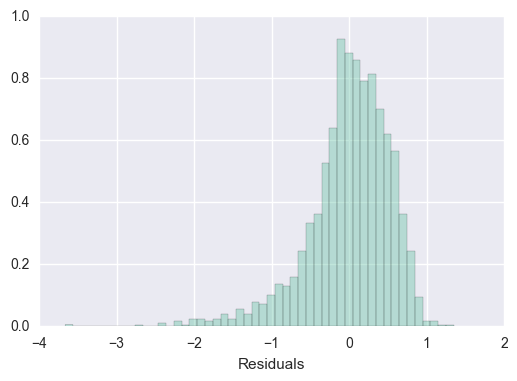

In [193]:
#Residual distribution
ax = sns.distplot(res, kde = False, rug = False, norm_hist = True)
plt.xlabel('Residuals')
plt.show()

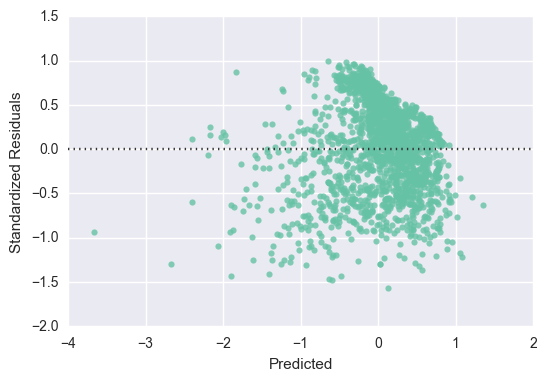

In [194]:
#Normal Residuals Plot
ax = sns.residplot(res, predicted)
plt.xlabel('Predicted')
ax.set_ylabel('Standardized Residuals')
plt.show()

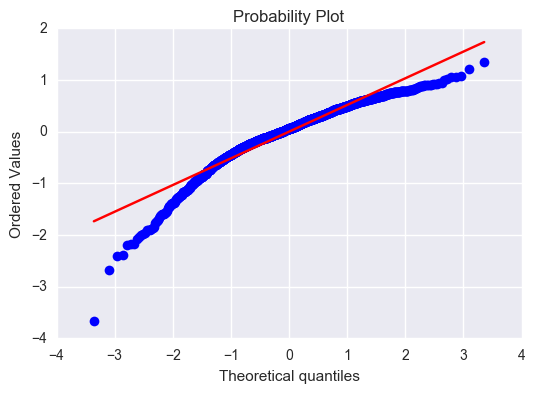

In [195]:
#Probability Plot
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(res, dist="norm", plot=pylab)
pylab.show()

# Predictions

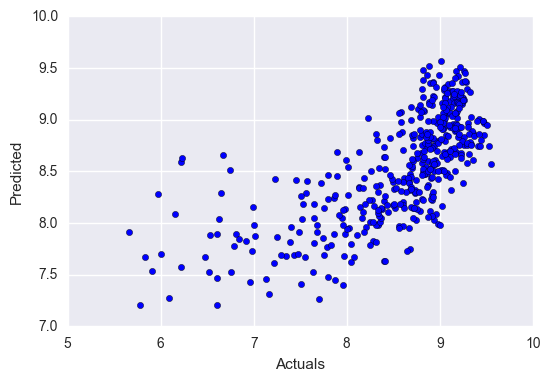

In [196]:
#Prediction on test set, plot predicted vs. actuals
preds = results.predict(X_test.astype(float))
plt.scatter(y_test, preds)
plt.xlabel('Actuals')
plt.ylabel('Predicted')